<a href="https://colab.research.google.com/github/quartermaine/Google-Colabs/blob/master/Predicting_a_pulsar_star.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting a Pulsar Star

In this notebook we are using the predicting-a-pulsar-star dataset from kaggle to train a Boosted trees classifier to make predictions between 2 classes { class of pulsar star = 1 ,class of not pulsar star = 0 } 


# Downloading the dataset and extract the data 

In [0]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

In [2]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 68 Nov  4 20:41 kaggle.json


In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [4]:
import os
print(os.listdir())

['.config', 'kaggle.json', 'sample_data']


In [0]:
# make kaggle directory
!mkdir -p ~/.kaggle

In [6]:
# move kaggle.json to .kaggle directory
!mv /content/kaggle.json ~/.kaggle

!chmod 600 ~/.kaggle/kaggle.json
# set the path to /content
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [7]:
# make data directory 
!mkdir -p data
# Download dataset
!kaggle datasets download -d pavanraj159/predicting-a-pulsar-star -p /content

  0% 0.00/771k [00:00<?, ?B/s]
100% 771k/771k [00:00<00:00, 50.7MB/s]


In [8]:
%tensorflow_version 2.x # use this to select tensorflow 2.0.0 ,not default for now
import os
import zipfile
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd 
import numpy as np
from IPython.display import clear_output
from sklearn.preprocessing import MinMaxScaler

print(tf.__version__)


TensorFlow 2.x selected.
2.0.0


In [0]:
# extract the files
local_zip = '/content/predicting-a-pulsar-star.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/predicting-a-pulsar-star')
zip_ref.close()

In [0]:
!rm predicting-a-pulsar-star.zip # remove the zip file 

# Exploratory Analysis and Data Standardizing

In [11]:
df=pd.read_csv("/content/predicting-a-pulsar-star/pulsar_stars.csv")
df.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
Mean of the integrated profile,17898.0,111.079968,25.652935,5.812500,100.929688,115.078125,127.085938,192.617188
Standard deviation of the integrated profile,17898.0,46.549532,6.843189,24.772042,42.376018,46.947479,51.023202,98.778911
Excess kurtosis of the integrated profile,17898.0,0.477857,1.064040,-1.876011,0.027098,0.223240,0.473325,8.069522
Skewness of the integrated profile,17898.0,1.770279,6.167913,-1.791886,-0.188572,0.198710,0.927783,68.101622
Mean of the DM-SNR curve,17898.0,12.614400,29.472897,0.213211,1.923077,2.801839,5.464256,223.392140
Standard deviation of the DM-SNR curve,17898.0,26.326515,19.470572,7.370432,14.437332,18.461316,28.428104,110.642211
Excess kurtosis of the DM-SNR curve,17898.0,8.303556,4.506092,-3.139270,5.781506,8.433515,10.702959,34.539844
Skewness of the DM-SNR curve,17898.0,104.857709,106.514540,-1.976976,34.960504,83.064556,139.309331,1191.000837
target_class,17898.0,0.091574,0.288432,0.000000,0.000000,0.000000,0.000000,1.000000


In [0]:
# we change the column names because we get error in training no {-,.} allowed in the column names
col_names = ['MeanIntegratedProfile', 'StandardDeviationIntegratedProfile','ExcesskurtosisIntegratedProfile',
              'SkewnessIntegratedProfile','MeanDMSNRcurve','StandardDeviationDMSNRcurve','ExcessKurtosisDMSNRcurve',
              'SkewnessDMSNRcurve','targetClass']
df.columns=col_names

In [13]:
df.dtypes # check the dtype of columns

MeanIntegratedProfile                 float64
StandardDeviationIntegratedProfile    float64
ExcesskurtosisIntegratedProfile       float64
SkewnessIntegratedProfile             float64
MeanDMSNRcurve                        float64
StandardDeviationDMSNRcurve           float64
ExcessKurtosisDMSNRcurve              float64
SkewnessDMSNRcurve                    float64
targetClass                             int64
dtype: object

In [0]:
y = np.array(df['targetClass']) # define the target variable with is targetClass

df_copy = df.iloc[:,:-1].copy()

features = df_copy.values
scaler = MinMaxScaler(feature_range=(0,1))

features_scaled = scaler.fit_transform(features)

#features_scaled = pd.DataFrame(features_scaled,columns=col_names[:-1])

In [0]:
df_scaled = pd.DataFrame(features_scaled,columns=col_names[:-1]) # create a new df for plotting 

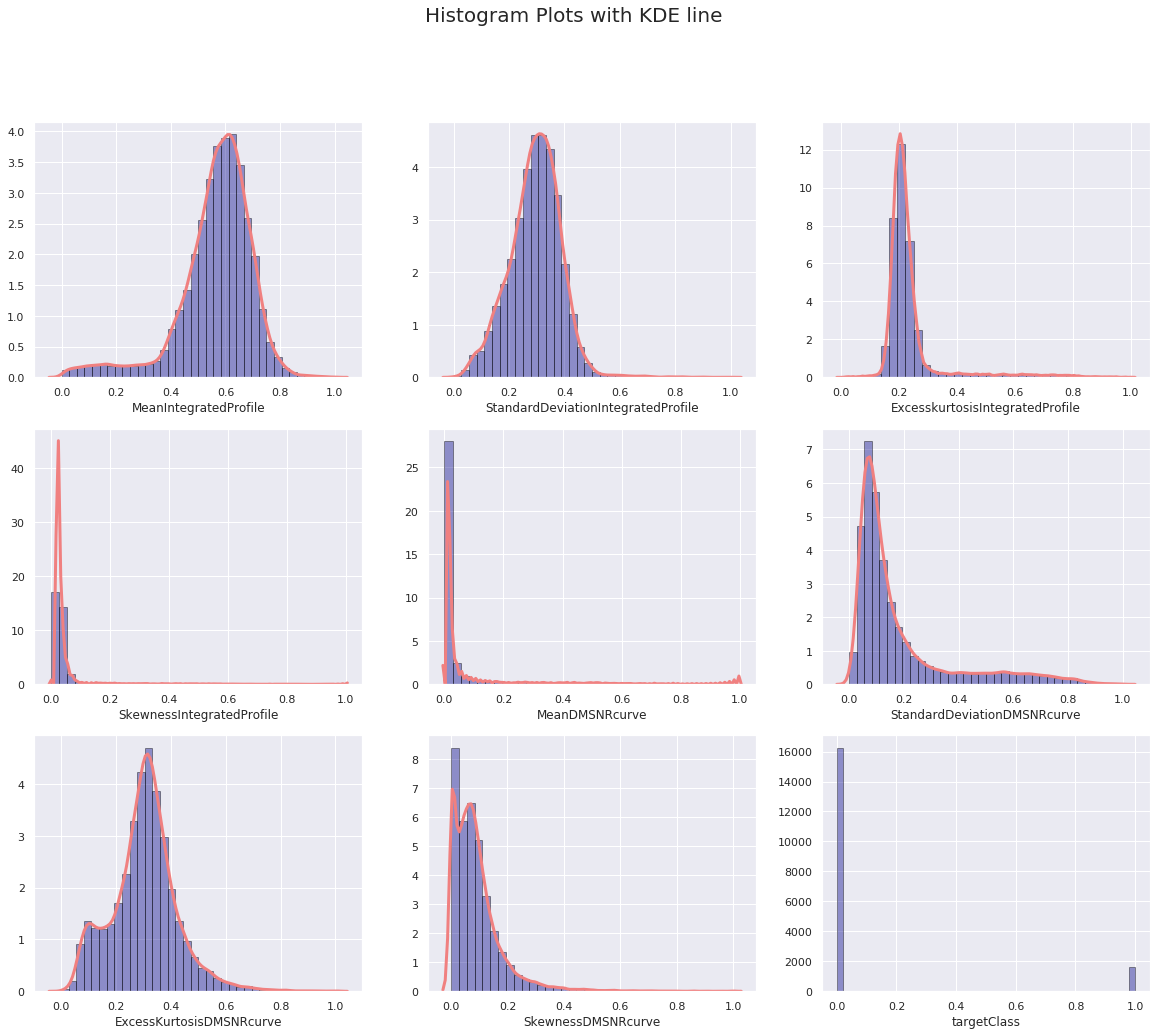

In [24]:
import seaborn as sns
sns.color_palette('dark')

sns.set(rc={'figure.figsize':(20,16)})
for i,name in enumerate(df.columns):
  if name!='targetClass':
    plt.subplot(3,3,i+1)
    sns.distplot(df_scaled[name], hist=True, kde=True,
                 bins=int(180/5),
                 hist_kws={'edgecolor':'black','color':'darkblue'},
                 kde_kws={'linewidth': 3,'color':'lightcoral'})
  else :
    plt.subplot(3,3,i+1)
    sns.distplot(df[name],kde=False,hist_kws={'edgecolor':'black','color':'darkblue'})
  
_ = plt.suptitle("Histogram Plots with KDE line",size=20)

As we can see in from the plot of targetClass we have imbalanced classes with the class of 0 to be dominant in the dataset.

In [0]:
# # histogram plots with matplotlib 

# plt.style.use(['tableau-colorblind10'])
# df.iloc[:,:-1].hist(layout=(4,2),figsize=(18,26),
#                     label=NUMERIC_COLUMNS,color='blue',histtype='stepfilled',
#                     bins=30)
# plt.show()

#plt.style.available

# Split Data and Handling Imbalanced Classes

In [0]:
# split the data to train,test with sklearn
X_train, X_test, y_train, y_test = train_test_split(features_scaled, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [18]:
bool_train_labels = y_train != 0

pos_features = X_train[bool_train_labels]
neg_features = X_train[~bool_train_labels]

pos_labels = y_train[bool_train_labels]
neg_labels = y_train[~bool_train_labels]

ids = np.arange(len(pos_features))

choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(12994, 8)

In [19]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features = pd.DataFrame(resampled_features,columns=col_names[:-1])

X_test = pd.DataFrame(X_test,columns=col_names[:-1])

resampled_labels = pd.Series(resampled_labels,name="targetClass",dtype="int64")

y_test = pd.Series(y_test,name="targetClass",dtype="int64")

resampled_features.shape

(25988, 8)

# Create feature columns and input functions

In [15]:
fc = tf.feature_column

NUMERIC_COLUMNS =  df.select_dtypes([np.float64]).columns

feature_columns = []

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(fc.numeric_column(feature_name,
                                           dtype=tf.float32))
print(feature_columns)

[NumericColumn(key='MeanIntegratedProfile', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='StandardDeviationIntegratedProfile', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='ExcesskurtosisIntegratedProfile', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='SkewnessIntegratedProfile', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='MeanDMSNRcurve', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='StandardDeviationDMSNRcurve', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='ExcessKurtosisDMSNRcurve', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='SkewnessDMSNRcurve', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


In [0]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((X.to_dict(orient='list'), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).
    dataset = (dataset.repeat(n_epochs).batch(NUM_EXAMPLES))
    return dataset
  return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(resampled_features, resampled_labels)
eval_input_fn = make_input_fn(X_test, y_test, shuffle=False, n_epochs=1)


# Train the Boosted Classifier

In [0]:
#accuracies={}
accuracy = {}
ntrees=100
#for trees in np.arange(50,200,10):
params = {
    'n_trees': ntrees,
    'max_depth': 10,
    'n_batches_per_layer': 1,
    # You must enable center_bias = True to get DFCs. This will force the model to
    # make an initial prediction before using any features (e.g. use the mean of
    # the training labels for regression or log odds for classification when
    # using cross entropy loss).
    'center_bias': True,
    #'weight_column': df['targetClass']
      }
est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
# Train model.
est.train(train_input_fn, max_steps=100)
# Evaluation.
#accuracies['ntrees='+str(trees)]=est.evaluate(eval_input_fn)['accuracy'] 
accuracy['ntrees='+str(ntrees)] = est.evaluate(eval_input_fn)['accuracy']
clear_output()



# Evaluate Accuracy

In [22]:
pd.Series(accuracy,name="Accuracy").to_frame()

,Accuracy
ntrees=100,0.971508


# Predicted Probabilities and ROC plots

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpxi1e07v0/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


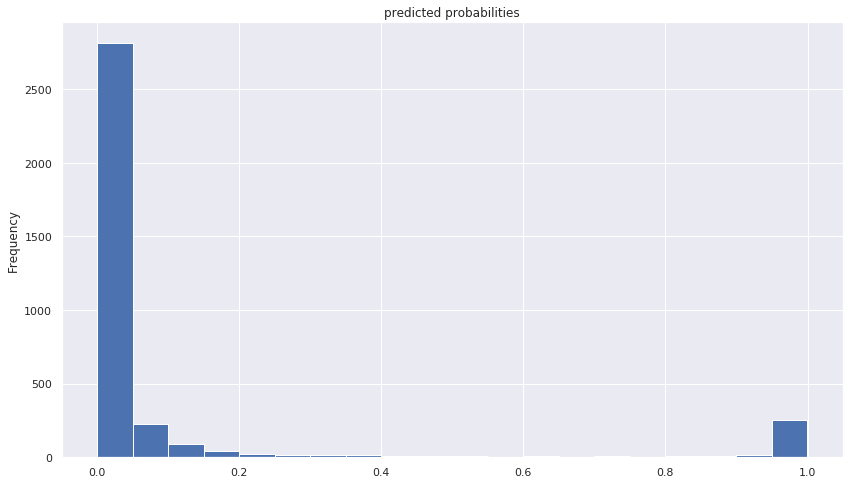

In [33]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

figsize=(12,16)
probs.plot(kind='hist', bins=20, title='predicted probabilities')
plt.show()


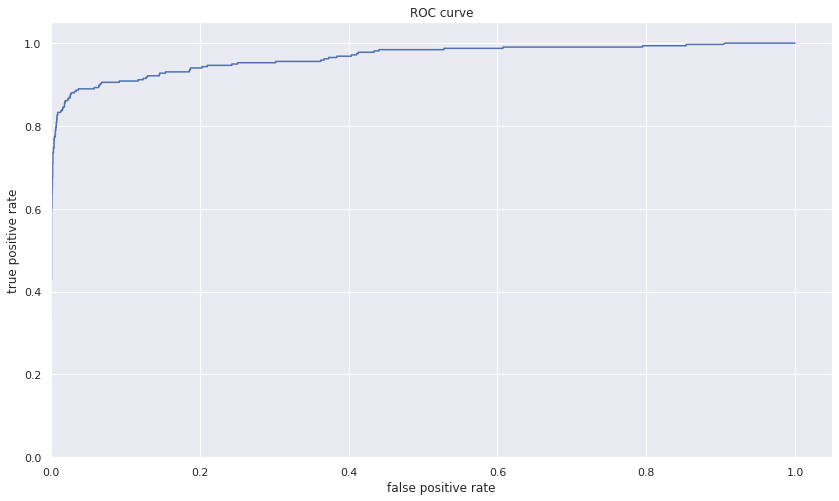

In [30]:
from sklearn.metrics import roc_curve

sns.set(rc={'figure.figsize':(14,8)})
fpr, tpr, _ = roc_curve(y_test, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()


# References

https://www.tensorflow.org/tutorials/estimator/boosted_trees

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#plot_the_roc_3